In [2]:
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable

In [3]:
class LRN(nn.Module):#这个网络貌似后续被其它正则化手段代替，如dropout、batch normalization等。目前该网络基本上很少使用了，这里为了原生的AlexNet而实现
    def __init__(self, local_size=1, alpha=1.0, beta=0.75, ACROSS_CHANNELS=False):
        super(LRN, self).__init__()
        self.ACROSS_CHANNELS = ACROSS_CHANNELS
        if self.ACROSS_CHANNELS:
            self.average=nn.AvgPool3d(kernel_size=(local_size, 1, 1), #0.2.0_4会报错，需要在最新的分支上AvgPool3d才有padding参数
                    stride=1,
                    padding=(int((local_size-1.0)/2), 0, 0)) 
        else:
            self.average=nn.AvgPool2d(kernel_size=local_size,
                    stride=1,
                    padding=int((local_size-1.0)/2))
        self.alpha = alpha
        self.beta = beta
    
    
    def forward(self, x):
        if self.ACROSS_CHANNELS:
            div = x.pow(2).unsqueeze(1)
            div = self.average(div).squeeze(1)
            div = div.mul(self.alpha).add(1.0).pow(self.beta)#这里的1.0即为bias
        else:
            div = x.pow(2)
            div = self.average(div)
            div = div.mul(self.alpha).add(1.0).pow(self.beta)
        x = x.div(div)
        return x

In [4]:
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable

import torch
class AlexNet(nn.Module):
    def __init__(self, num_classes = 1000):#imagenet数量
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            LRN(local_size=5, alpha=1e-4, beta=0.75, ACROSS_CHANNELS=True)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, groups=2, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            LRN(local_size=5, alpha=1e-4, beta=0.75, ACROSS_CHANNELS=True)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=384, padding=1, kernel_size=3),
            nn.ReLU(inplace=True)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
         #需要针对上一层改变view
        self.layer6 = nn.Sequential(
            nn.Linear(in_features=6*6*256, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout()
        )
        self.layer7 = nn.Sequential(
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout()
        )
        
        self.layer8 = nn.Linear(in_features=4096, out_features=num_classes)
        
    def forward(self, x):
        x = self.layer5(self.layer4(self.layer3(self.layer2(self.layer1(x)))))
        x = x.view(-1, 6*6*256)
        x = self.layer8(self.layer7(self.layer6(x)))
        
        return x

In [5]:
model = AlexNet(1000)
model

AlexNet (
  (layer1): Sequential (
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU (inplace)
    (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (3): LRN (
      (average): AvgPool3d (size=(5, 1, 1), stride=1, padding=(2, 0, 0), ceil_mode=False, count_include_pad=True)
    )
  )
  (layer2): Sequential (
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=2)
    (1): ReLU (inplace)
    (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (3): LRN (
      (average): AvgPool3d (size=(5, 1, 1), stride=1, padding=(2, 0, 0), ceil_mode=False, count_include_pad=True)
    )
  )
  (layer3): Sequential (
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
  )
  (layer4): Sequential (
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
  )
  (layer5): Sequential (
    (0): Conv2d(384, 256, kernel_size=(3, 3), stride=

In [20]:
import pandas as pd
import numpy as np

import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets

#用于不均匀样本抽样的权重计算,在本次imagenet中其实未使用到
def make_weights_for_balanced_classes(images, nclasses):                        
    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
train_dataset = datasets.ImageFolder('./data/ILSVRC/Data/CLS-LOC/train/', 
        transforms.Compose([
                transforms.RandomSizedCrop(227), #AlexNet输入
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                normalize
        ]))

weights = make_weights_for_balanced_classes(train_dataset.imgs, len(train_dataset.classes))
weights = torch.DoubleTensor(weights)
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))

batch_size = 256
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size, 
                                           num_workers=2, 
                                           pin_memory=True, 
                                           sampler=sampler
                                          )

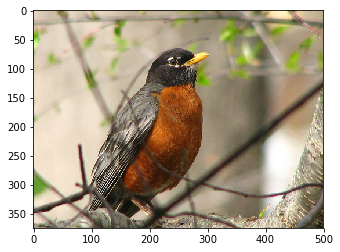

In [10]:
from PIL import Image
import sys
im = Image.open(train_dataset.imgs[20000][0])
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(im)

In [ ]:
def weight_init(m):
# 使用isinstance来判断m属于什么类型
    if isinstance(m, nn.Conv2d):
        import math
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2. / n))
    elif isinstance(m, nn.BatchNorm2d):
# m中的weight，bias其实都是Variable，为了能学习参数以及后向传播
        m.weight.data.fill_(1)
        m.bias.data.zero_()
        
model = AlexNet(len(train_dataset.classes))
model.apply(weight_init)
use_gpu = torch.cuda.is_available()
if use_gpu:
    model = model.cuda()
    print('USE GPU')
else:
    print('USE CPU')

criterion = nn.CrossEntropyLoss(size_average=False)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.99))

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_gpu:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))
            

for epoch in range(1, 5):
    train(epoch)